<font size="-1">
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
            <b>3D Object Representations for Fine-Grained Categorization</b><br>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
            Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei<br>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
            <i>4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013</i> <b>(3dRR-13)</b>. Sydney, Australia. Dec. 8, 2013.<br>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
            <a style="text-decoration: underline" href="../papers/3drr13.pdf">[pdf]</a>
            &nbsp;&nbsp;<a style="text-decoration: underline" href="../papers/3drr13.bib">[BibTex]</a>
            &nbsp;&nbsp;<a style="text-decoration: underline" href="../papers/3drr_talk.pdf">[slides]</a>
</font>

Pour créer un env dédié:
conda create -n cars numpy=1.19.1 scipy tensorflow keras matplotlib notebook pandas Pillow
Ressources utilisées :  
https://medium.com/swlh/recognising-cats-and-dogs-using-neural-networks-with-tensorflow-6f366ad30dbf  
https://towardsdatascience.com/how-to-load-matlab-mat-files-in-python-1f200e1287b5  
  
    
Besoin de 3 datasets:
- training 
- validation
- test

Tout est fourni dans le dataset  choisi

dataset from https://ai.stanford.edu/~jkrause/cars/car_dataset.html  
NB: Does not feature a lot of french car brands

In [2]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

print("imports ok")

imports ok


In [3]:
#import des infos sur les classes de voitures
from scipy.io import loadmat
meta_annot = loadmat('car_devkit\cars_meta.mat')
data = [[row.flat[0] for row in line] for line in meta_annot['class_names'][0]]
print(len(data))
columns = ["model_id", "class_name",]
df_names = pd.DataFrame(list(zip(range( 1,len(data)+1), data)), columns=columns)
df_names.head()

196


,model_id,class_name
0,1,[AM General Hummer SUV 2000]
1,2,[Acura RL Sedan 2012]
2,3,[Acura TL Sedan 2012]
3,4,[Acura TL Type-S 2008]
4,5,[Acura TSX Sedan 2012]


In [4]:
#Il faut maintenant regrouper les classes de véhicules par marque au lieu du modèle
df_names["b_name"] = df_names.class_name.astype(str).apply(lambda x: x.split(" ")[0].replace("['",""))
df_names["b_name"] = df_names["b_name"].apply(lambda x: "AM General" if x=="AM" else x)
df_names["b_id"] = pd.factorize(df_names["b_name"])[0] #creation du nouvel index
# set(df_names.cnames.tolist()) #visualisation de la liste des marques
# df_names.b_name.value_counts() #nombre de modèles dans le dataset par marque
# df_names.b_id.value_counts() #nombre de répétitions des identifiants de marque pour validation
df_names

,model_id,class_name,b_name,b_id
0,1,[AM General Hummer SUV 2000],AM General,0
1,2,[Acura RL Sedan 2012],Acura,1
2,3,[Acura TL Sedan 2012],Acura,1
3,4,[Acura TL Type-S 2008],Acura,1
4,5,[Acura TSX Sedan 2012],Acura,1
...,...,...,...,...
191,192,[Volkswagen Beetle Hatchback 2012],Volkswagen,46
192,193,[Volvo C30 Hatchback 2012],Volvo,47
193,194,[Volvo 240 Sedan 1993],Volvo,47
194,195,[Volvo XC90 SUV 2007],Volvo,47


In [5]:
#création d'un dict pour convertir facilement les model_id en b_id
id_conv= dict(zip(df_names["model_id"],df_names["b_id"]))
# pour obtenir le numéro de marque du modèle #44 :
print(df_names.loc[df_names['model_id'] == 44])
print()
print(f"{id_conv[44]=}")

#idem pour les noms de marques:
name_conv= dict(zip(df_names["b_id"],df_names["b_name"]))

    model_id                                    class_name   b_name  b_id
43        44  [Bentley Continental Flying Spur Sedan 2007]  Bentley     5

id_conv[44]=5


In [6]:
#import des annotations de training depuis le fichier matlab
from scipy.io import loadmat

mat_annot = loadmat('car_devkit\cars_train_annos.mat')
data = [[row.flat[0] for row in line] for line in mat_annot['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(data, columns=columns)
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg


In [7]:
#ajouter les b_id à la dataframe en utilisant le dict et apply:
df_train["b_id"] = df_train["class"].apply(lambda x: id_conv[x])
# reordering the df
df_train = df_train [["bbox_x1", "bbox_y1","bbox_x2","bbox_y2","class", "b_id", "fname"]]
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,b_id,fname
0,39,116,569,375,14,3,00001.jpg
1,36,116,868,587,3,1,00002.jpg
2,85,109,601,381,91,12,00003.jpg
3,621,393,1484,1096,134,22,00004.jpg
4,14,36,133,99,106,17,00005.jpg


In [8]:
#nombre d'images par marque de voiture :
df_train.b_id.apply(lambda x: name_conv[x]).value_counts()

Chevrolet        905
Dodge            630
Audi             589
BMW              531
Ford             521
Hyundai          438
Mercedes-Benz    261
Chrysler         260
Acura            242
Bentley          238
GMC              238
Jeep             220
Nissan           171
Toyota           168
Suzuki           167
Ferrari          164
Lamborghini      161
Honda            161
Buick            158
Aston            157
Volkswagen       132
Volvo            131
Cadillac         129
Rolls-Royce      114
Spyker            88
Land              86
HUMMER            83
Bugatti           77
Infiniti          67
FIAT              62
Mitsubishi        48
Jaguar            47
Eagle             46
Geo               45
Daewoo            45
AM General        45
McLaren           44
Porsche           44
Plymouth          44
Fisker            44
Scion             42
Ram               41
smart             40
Isuzu             40
Lincoln           39
Tesla             39
MINI              37
Mazda        

In [9]:
#import des infos de test 
# sera peut-être utile plus tard :)
from scipy.io import loadmat
test_annot = loadmat('car_devkit\cars_test_annos.mat')
data = [[row.flat[0] for row in line] for line in test_annot['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test = pd.DataFrame(data, columns=columns)
df_test.head()
#we are not sending our results -> this may be useless

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,00001.jpg
1,100,19,576,203,00002.jpg
2,51,105,968,659,00003.jpg
3,67,84,581,407,00004.jpg
4,140,151,593,339,00005.jpg


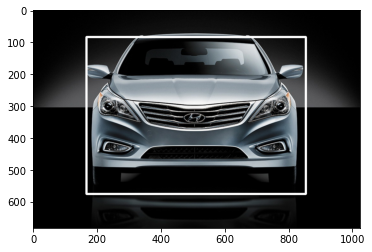

In [44]:
import matplotlib.pyplot as plt

#fonction pour plotter les box sur les images
def draw_rect(row, color = None):
    
    img_f = plt.imread(r"cars_train\\" + row['fname'], format='jpeg')
    
    if not color:
        color = [255,255,255]
        
    pt1, pt2 = (row['bbox_x1'], row['bbox_y1']) , (row['bbox_x2'], row['bbox_y2'])
    pt1 = int(pt1[0]), int(pt1[1])
    pt2 = int(pt2[0]), int(pt2[1])
    img_f = cv2.rectangle(img_f.copy(), pt1, pt2, color, int(max(img_f.shape[:2])/200))
    
    return img_f

# this synthax can be used to draw bounding boxes on the images
plt.imshow(draw_rect(df_train.iloc[686]))

In [11]:
# ouvrir une image avec numpy:
img = plt.imread(r"cars_train\00001.jpg", format='jpeg')

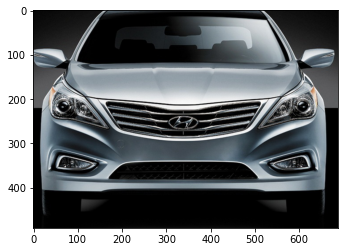

In [43]:
import cv2

#fonction pour plotter les box sur les images
def crop_img(row):
    img_f = plt.imread(r"cars_train\\" + row['fname'], format='jpeg')
    # x and y are flipped when slicing 😠 np arrays
    return img_f[row['bbox_y1']:row['bbox_y2'], row['bbox_x1']:row['bbox_x2']]

# this synthax can be used to crop the images
plt.imshow(crop_img(df_train.iloc[686]))


In [93]:
#splitting the training dataframe into training, validation and test dfs
# litterature suggests :
#  70% of the entire Dataset for training (Training data) : df_flow_train
#  15% of the entire Dataset for validation (Validation data): df_flow_val
#  15% of the entire Dataset for testing (Testing data): df_flow_test
# one issue here : if our sampling is is not representative, we can end up with unbalanced datasets

# creating the empty dfs:
column_names = [col for col in df_train.columns]
df_flow_train  = pd.DataFrame(columns = column_names) 
df_flow_val  = pd.DataFrame(columns = column_names) 
df_flow_test  = pd.DataFrame(columns = column_names) 

# we need to sample x amount for each class instead of for the entire df:

for i in range(df_train['b_id'].max()+1):
    df_flow_train = df_flow_train.append(df_train[df_train['b_id']==i].sample(frac = 0.7))

df_train_rest = df_train.drop(df_flow_train.index) 

for i in range(df_train['b_id'].max()+1):
    df_flow_val = df_flow_val.append(df_train_rest[df_train_rest['b_id']==i].sample(frac = 0.5))

df_flow_test = df_train_rest.drop(df_flow_val.index) 

#checking the datasets len():
print(len(df_flow_train))
print(len(df_flow_val))
print(len(df_flow_test))

#checking if we have duplicates, should be 0
print(len(df_flow_train[df_flow_train.duplicated()]))
print(len(df_flow_val[df_flow_val.duplicated()]))
print(len(df_flow_test[df_flow_test.duplicated()]))

#checking if we have overlap in the datasets, should be 0
remerged = df_flow_train.append(df_flow_val).append(df_flow_test)
print(len(remerged[remerged.duplicated()]))


5703
1222
1219
0
0
0
0


In [127]:
# adding a cat column to use for the classifier
df_flow_train["cat_str"] = df_flow_train["b_id"].apply(lambda x: name_conv[x])
df_flow_val["cat_str"] = df_flow_val["b_id"].apply(lambda x: name_conv[x])
df_flow_test["cat_str"] = df_flow_test["b_id"].apply(lambda x: name_conv[x])

df_flow_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,b_id,fname,cat_str
5029,60,76,593,393,1,0,05030.jpg,AM General
1831,29,18,157,86,1,0,01832.jpg,AM General
2049,30,65,331,199,1,0,02050.jpg,AM General
3007,13,235,2021,1253,1,0,03008.jpg,AM General
2847,51,73,570,426,1,0,02848.jpg,AM General


In [103]:
# danger zone : cropping 7k images at once, what could go wrong lol
# don't overwrite the initial images! Uncomment and remove # in the middle to use
# df_train.apply(#lambda x: cv2.imwrite(r"cars_cropped\\" + x['fname'], crop_img(x)), axis=1)

0       True
1       True
2       True
3       True
4       True
        ... 
8139    True
8140    True
8141    True
8142    True
8143    True
Length: 8144, dtype: bool

In [128]:
img_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.1, shear_range=0.1)
img_size = 200
batch_size = 32

train_img_gen = img_gen.flow_from_dataframe(dataframe= df_flow_train,
                                            directory="cars_cropped\\",
                                            x_col = "fname",
                                            y_col = "cat_str",
                                            batch_size = batch_size,
                                            target_size=(img_size, img_size),
                                            class_mode = "raw"
                                           )

validate_img_gen = img_gen.flow_from_dataframe(dataframe= df_flow_val,
                                            directory="cars_cropped\\",
                                            x_col = "fname",
                                            y_col = "cat_str",
                                            batch_size = batch_size,
                                            target_size=(img_size, img_size),
                                           )

test_img_gen = img_gen.flow_from_dataframe(dataframe= df_flow_test,
                                            directory="cars_cropped\\",
                                            x_col = "fname",
                                            y_col = "cat_str",
                                            batch_size = batch_size,
                                            target_size=(img_size, img_size),
                                           )

Found 5703 validated image filenames.
Found 1222 validated image filenames belonging to 49 classes.
Found 1219 validated image filenames belonging to 49 classes.


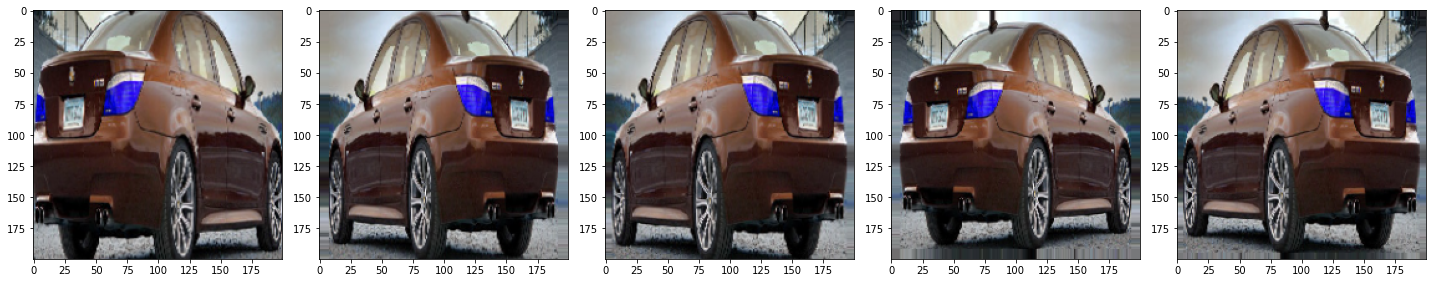

In [129]:
def showImages(arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
showImages([train_img_gen[0][0][0] for i in range(15)])

In [140]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(df_train['b_id'].max(), activation='softmax'))


In [141]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', # feed the model to the optimizer
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
activation_17 (Activation)   (None, 97, 97, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 46, 46, 128)      

In [142]:
#training
train_total = len(df_flow_train)
validate_total = len(df_flow_val)
# batch_size = 32 #defined earlier

fit_result = model.fit(
            train_img_gen,
            steps_per_epoch=int(np.ceil(train_total / float(batch_size))),
            epochs=5, 
            validation_data=validate_img_gen,
            validation_steps=int(np.ceil(validate_total / float(batch_size)))
            )

Epoch 1/5


ValueError: in user code:

    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    H:\Programmes\Ancaconda\envs\cars\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 48) are incompatible


In [ ]:
print(fit_result.history['accuracy'])